<h1>4. Machine Learning Model XG Boost </h1>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [31]:
xg_train=pd.read_csv('final_train_data.csv')
xg_train=xg_train.drop(['Unnamed: 0'],axis=1)
xg_train.columns

xg_cv=pd.read_csv('final_cv_data.csv')
xg_cv=xg_cv.drop(['Unnamed: 0'],axis=1)
xg_cv.columns

xg_test=pd.read_csv('final_test_data.csv')
xg_test=xg_test.drop(['Unnamed: 0'],axis=1)
xg_test.columns

Index(['id', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       ...
       '86.1', '87.1', '88.1', '89.1', '90.1', '91.1', '92.1', '93.1', '94.1',
       '95.1'],
      dtype='object', length=220)

In [79]:
x_train_data=xg_train_df.drop(['is_duplicate'],axis=1)
y_train_data=xg_train_df['is_duplicate']
for i in x_train_data:
    x_train_data[i]=x_train_data[i].apply(pd.to_numeric)
print(x_train_data.shape,y_train_data.shape)

x_cv_data=xg_cv_df.drop(['is_duplicate'],axis=1)
y_cv_data=xg_cv_df['is_duplicate']
for i in x_cv_data:
    x_cv_data[i]=x_cv_data[i].apply(pd.to_numeric)
print(x_cv_data.shape,y_cv_data.shape)

x_test_data=xg_test_df.drop(['is_duplicate'],axis=1)
y_test_data=xg_test_df['is_duplicate']
for i in x_test_data:
    x_test_data[i]=x_test_data[i].apply(pd.to_numeric)
print(x_test_data.shape,y_test_data.shape)

(49000, 219) (49000,)
(21000, 219) (21000,)
(30000, 219) (30000,)


In [97]:
x_final_train_data=pd.DataFrame(x_train_data)
x_final_cv_data=pd.DataFrame(x_cv_data)
x_final_test_data=pd.DataFrame(x_test_data)

y_final_train_data=pd.DataFrame(y_train_data)
y_final_cv_data=pd.DataFrame(y_cv_data)
y_final_test_data=pd.DataFrame(y_test_data)


<h3> custom confusion matrix Precision matrix Recall matrix </h3>

In [58]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [93]:
print("x_train_data,y_train_data")
print("x_cv_data,y_cv_data")
print("x_test_data,y_test_data")

x_train_data,y_train_data
x_cv_data,y_cv_data
x_test_data,y_test_data


<h2> 4.6 XGBoost </h2>

In [104]:
import xgboost as xgb

train_log = []
cv_log = []
max_depth = [1, 5, 10, 50, 100, 500,700,800,900 ,1000]
n_models =[10,20,30,40,50,60,70,80,90,100]

for i in max_depth:
    clf = xgb.XGBClassifier(max_depth=i,n_jobs=2)
    clf.fit(x_train_data, y_train_data)
    xgb_model = CalibratedClassifierCV(clf, method="sigmoid")
    xgb_model.fit(x_train_data, y_train_data)
    y_train_pred =  xgb_model.predict_proba(x_train_data)
    y_cv_pred =  xgb_model.predict_proba(x_cv_data)
    train_log_score=log_loss(y_train_data,y_train_pred)
    train_log.append(train_log_score)
    cv_log_score=log_loss(y_cv_data, y_cv_pred)
    cv_log.append(cv_log_score)
    print("Best_depth = ",i ,"\t","cv_log_score\t:",cv_log_score, "\t","train_log_score\t:",train_log_score)

Best_depth =  1 	 cv_log_score	: 0.41998682289175276 	 train_log_score	: 0.42070775736185495
Best_depth =  5 	 cv_log_score	: 0.35602745870383345 	 train_log_score	: 0.3166492167578133
Best_depth =  10 	 cv_log_score	: 0.35638636488720044 	 train_log_score	: 0.16301454167226231
Best_depth =  50 	 cv_log_score	: 0.37192939171101824 	 train_log_score	: 0.15688841612651705
Best_depth =  100 	 cv_log_score	: 0.37192939171101824 	 train_log_score	: 0.15688841612651705
Best_depth =  500 	 cv_log_score	: 0.37192939171101824 	 train_log_score	: 0.15688841612651705
Best_depth =  700 	 cv_log_score	: 0.37192939171101824 	 train_log_score	: 0.15688841612651705
Best_depth =  800 	 cv_log_score	: 0.37192939171101824 	 train_log_score	: 0.15688841612651705
Best_depth =  900 	 cv_log_score	: 0.37192939171101824 	 train_log_score	: 0.15688841612651705
Best_depth =  1000 	 cv_log_score	: 0.37192939171101824 	 train_log_score	: 0.15688841612651705


In [106]:
best_depth = np.argmin(cv_log)

train_auc_tfidfw2v=[]
cv_auc_tfidfw2v=[]

for j in n_models:
    clf = xgb.XGBClassifier(max_depth=max_depth[best_depth],n_estimators=j,n_jobs=2)
    clf.fit(x_train_data, y_train_data)
    xgb_model = CalibratedClassifierCV(clf, method="sigmoid")
    xgb_model.fit(x_train_data, y_train_data)
    y_train_pred =  xgb_model.predict_proba(x_train_data)
    y_cv_pred =  xgb_model.predict_proba(x_cv_data)
    train_log_score=log_loss(y_train_data,y_train_pred)
    train_auc_tfidfw2v.append(train_log_score)
    cv_log_score=log_loss(y_cv_data, y_cv_pred)
    cv_auc_tfidfw2v.append(cv_log_score)
    print("Best_estimator = ",j ,"\t","cv_log_score\t:",cv_log_score, "\t","train_log_score\t:",train_log_score)

best_estimators = np.argmin(cv_auc_tfidfw2v)

Best_estimator =  10 	 cv_log_score	: 0.3846670481528824 	 train_log_score	: 0.38398479167613714
Best_estimator =  20 	 cv_log_score	: 0.37496218035193696 	 train_log_score	: 0.3712313889369485
Best_estimator =  30 	 cv_log_score	: 0.37058605204941253 	 train_log_score	: 0.36332021981448226
Best_estimator =  40 	 cv_log_score	: 0.36740566179919754 	 train_log_score	: 0.35670085486038844
Best_estimator =  50 	 cv_log_score	: 0.36491606590453923 	 train_log_score	: 0.3504763374553276
Best_estimator =  60 	 cv_log_score	: 0.36217660686154074 	 train_log_score	: 0.3434987162245954
Best_estimator =  70 	 cv_log_score	: 0.35944373252265505 	 train_log_score	: 0.3357474920561014
Best_estimator =  80 	 cv_log_score	: 0.3580194204136973 	 train_log_score	: 0.3285019354633564
Best_estimator =  90 	 cv_log_score	: 0.35695259345942093 	 train_log_score	: 0.32250532220875905
Best_estimator =  100 	 cv_log_score	: 0.35602745870383345 	 train_log_score	: 0.3166492167578133


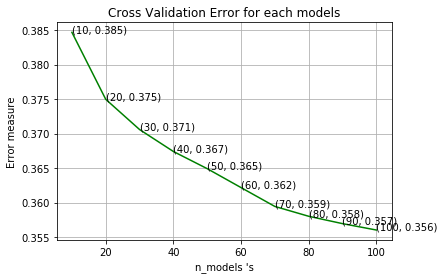

In [107]:
#plotting
fig, ax = plt.subplots()
ax.plot(n_models, cv_auc_tfidfw2v,c='g')
for i, txt in enumerate(np.round(cv_auc_tfidfw2v,3)):
    ax.annotate((n_models[i],np.round(txt,3)), (n_models[i],cv_auc_tfidfw2v[i]))
plt.grid()
plt.title("Cross Validation Error for each models")
plt.xlabel("n_models 's")
plt.ylabel("Error measure")
plt.show()

For values of best estimators =  100 The train log loss is: 0.3166492167578133
For values of best alpha =  100 The test log loss is: 0.352386219244619
Total number of data points : 30000


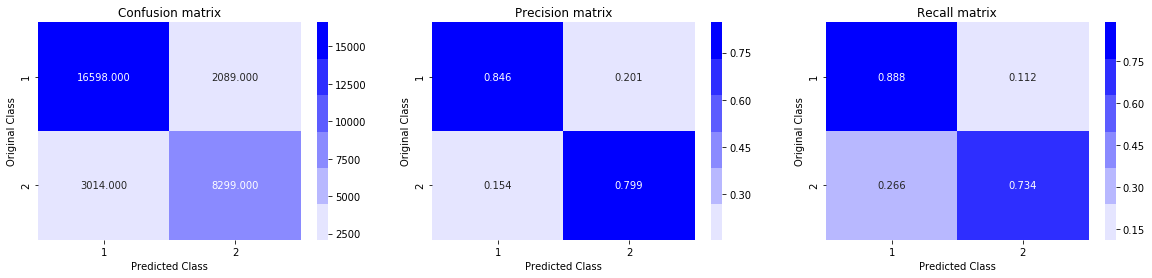

In [108]:
clf = xgb.XGBClassifier(max_depth=max_depth[best_depth],n_estimators=n_models[best_estimators])
clf.fit(x_train_data, y_train_data)
xg_clf = CalibratedClassifierCV(clf, method="sigmoid")
xg_clf.fit(x_train_data, y_train_data)

predict_y = xg_clf.predict_proba(x_train_data)
print('For values of best estimators = ',n_models[best_estimators], "The train log loss is:",log_loss(y_train_data, predict_y,))
predict_y = xg_clf.predict_proba(x_test_data)
print('For values of best alpha = ',n_models[best_estimators],"The test log loss is:",log_loss(y_test_data, predict_y,))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_data, predicted_y)

In [111]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = [ "Model","vectorizer", "alpha", "Train_log_loss","test_log_loss"]

x.add_row(["Xg-BOOST","TFIDFW2V",100,0.31,0.35])
x.add_row(["Logistic","TFIDF",0.0001,0.65,0.65])
x.add_row(["SVM","TFIDF",0.0001, 0.65,0.65])
print(x)

+----------+------------+--------+----------------+---------------+
|  Model   | vectorizer | alpha  | Train_log_loss | test_log_loss |
+----------+------------+--------+----------------+---------------+
| Xg-BOOST |  TFIDFW2V  |  100   |      0.31      |      0.35     |
| Logistic |   TFIDF    | 0.0001 |      0.65      |      0.65     |
|   SVM    |   TFIDF    | 0.0001 |      0.65      |      0.65     |
+----------+------------+--------+----------------+---------------+


<h3>Observation on XG-BOOST</h3>

1. We used TFIDFW2V features in XG-BOOST <br>
2. Compare to Logistic Regression and SVM Xg-Boost gives better results <br>
3. It gives good Precision and Recall and Good confusion matrix results Compared to Logistic regression and SVM <br>
4. over all performance Xg-boost gives good model results compared to Logistic regression and SVM (with SGD classifier)